In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data importation

In [3]:
population_df = pd.read_csv("country_population.csv")
fertility_rate_df = pd.read_csv("fertility_rate.csv")
life_expectancy_df = pd.read_csv("life_expectancy.csv")

In [4]:
population_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1733404.0,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,21751605.0,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,49887181.0,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,12725974.0,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0


# Data processing

In [5]:
# Select last 6 years
population_df_last_6 = population_df[["Country Name", '2011', '2012', '2013', '2014', '2015', '2016']]
fertility_rate_df_last_6 = fertility_rate_df[["Country Name", '2011', '2012', '2013', '2014', '2015', '2016']]
life_expectancy_df_last_6 = life_expectancy_df[["Country Name", '2011', '2012', '2013', '2014', '2015', '2016']]

In [6]:
# Make a list of the indexes with rows with na's
na_population = population_df_last_6[population_df_last_6.isna().any(axis=1)].index.tolist()
na_fertility = fertility_rate_df_last_6[fertility_rate_df_last_6.isna().any(axis=1)].index.tolist()
na_expectancy = life_expectancy_df_last_6[life_expectancy_df_last_6.isna().any(axis=1)].index.tolist()
result_na = list(set(na_population) | set(na_fertility) | set(na_expectancy))

In [7]:
# Drop na's
population_df_last_6 = population_df_last_6.drop(index=result_na).reset_index(drop=True)
life_expectancy_df_last_6 = life_expectancy_df_last_6.drop(index=result_na).reset_index(drop=True)
fertility_rate_df_last_6 = fertility_rate_df_last_6.drop(index=result_na).reset_index(drop=True)

In [8]:
def deltas_df(df):
    result = pd.DataFrame()
    d1 = df['2012'] - df['2011']
    d2 = df['2013'] - df['2012']
    d3 = df['2014'] - df['2013']
    d4 = df['2015'] - df['2014']
    d5 = df['2016'] - df['2015']
    result['D0'] = pd.concat([d1, d2], axis = 1).stack().reset_index()[[0]]
    result['D1'] = pd.concat([d2, d3], axis = 1).stack().reset_index()[[0]]
    result['D2'] = pd.concat([d3, d4], axis = 1).stack().reset_index()[[0]]
    result['D3'] = pd.concat([d4, d5], axis = 1).stack().reset_index()[[0]]
    return result

In [9]:
pop_deltas = deltas_df(population_df_last_6)
pop_deltas

,D0,D1,D2,D3
0,524.0,610.0,608.0,546.0
1,610.0,608.0,546.0,481.0
2,988359.0,1034730.0,1026332.0,978474.0
3,1034730.0,1026332.0,978474.0,919538.0
4,877585.0,902190.0,922126.0,938839.0
...,...,...,...,...
481,769183.0,772175.0,751654.0,724248.0
482,435181.0,453273.0,467764.0,479613.0
483,453273.0,467764.0,479613.0,490803.0
484,324177.0,343680.0,357169.0,365776.0


In [10]:
le_deltas = deltas_df(life_expectancy_df_last_6)
le_deltas

,D0,D1,D2,D3
0,0.141,0.141,0.142,0.143
1,0.141,0.142,0.143,0.142
2,0.420,0.408,0.401,0.393
3,0.408,0.401,0.393,0.385
4,0.728,0.603,0.485,0.383
...,...,...,...,...
481,1.285,1.163,0.988,0.793
482,1.139,0.971,0.793,0.622
483,0.971,0.793,0.622,0.477
484,1.716,1.537,1.307,1.038


In [11]:
fr_deltas = deltas_df(fertility_rate_df_last_6)
fr_deltas

,D0,D1,D2,D3
0,0.008,0.005,0.004,0.001
1,0.005,0.004,0.001,-0.001
2,-0.215,-0.206,-0.193,-0.179
3,-0.206,-0.193,-0.179,-0.167
4,-0.082,-0.080,-0.079,-0.075
...,...,...,...,...
481,-0.021,-0.023,-0.025,-0.027
482,-0.076,-0.071,-0.067,-0.063
483,-0.071,-0.067,-0.063,-0.060
484,-0.023,-0.039,-0.054,-0.067


# Models

In [12]:
# Function to evaluate models
def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    #corr, pval = pearsonr(truth, preds)
    #print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))

### Population

In [13]:
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(pop_deltas[['D0', 'D1', 'D2']], pop_deltas[['D3']], test_size=0.25)

#### Linear regression

In [14]:
lr = LinearRegression()

In [15]:
lr.fit(X_train_pop, y_train_pop)

LinearRegression()

In [16]:
predslr = lr.predict(X_test_pop)

In [17]:
lr.score(X_test_pop, y_test_pop)

0.9999516277178392

In [18]:
printRegStatistics(y_test_pop, predslr)

The RVE is:  0.9999525137810349
The rmse is:  81494.34971659307
The Maximum Error is is:  435033.2917512851
The Mean Absolute Error is:  36651.47682376531


#### XGBoost


In [19]:
xgb_params = {
    "learning_rate": (0.05, 0.10, 0.15),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
    "colsample_bytree":[ 0.3, 0.4]
}

xgb = XGBRegressor(verbosity = 0)
xgbgs = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring="neg_root_mean_squared_error")
xgbgs = xgbgs.fit(X_train_pop, y_train_pop)

In [20]:
xgbgs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [21]:
predsxgb = xgbgs.best_estimator_.predict(X_test_pop)

In [22]:
printRegStatistics(y_test_pop, predsxgb)

The RVE is:  0.999848938403586
The rmse is:  144703.40568787223
The Maximum Error is is:  883446.0
The Mean Absolute Error is:  59737.23961001537


#### MLP

In [23]:
scaler_pop = StandardScaler()
scaler_pop.fit(X_train_pop)
X_train_scaled = scaler_pop.transform(X_train_pop)
X_test_scaled = scaler_pop.transform(X_test_pop)

In [24]:
mlp_params = {
    "activation":['identity', 'relu'],
    "solver":['lbfgs', 'sgd', 'adam'],
    "hidden_layer_sizes": [(10,),(50,),(100,)],
    "alpha": [0.0001, 0.01, 0.1, 1]
}

mlp = MLPRegressor()
mlpgs = GridSearchCV(estimator=mlp, param_grid=mlp_params, scoring="neg_root_mean_squared_error")
mlpgs = mlpgs.fit(X_train_scaled, y_train_pop)

In [25]:
mlpgs.best_estimator_

MLPRegressor(alpha=1, solver='lbfgs')

In [26]:
predsmlp = mlpgs.best_estimator_.predict(X_test_scaled)

In [27]:
printRegStatistics(y_test_pop, predsmlp)

The RVE is:  0.9999575698032417
The rmse is:  76674.61642138011
The Maximum Error is is:  440792.84928962216
The Mean Absolute Error is:  33563.24583469129


#### Best

In [28]:
best_model_pop = mlpgs.best_estimator_

### Fertility Rate

In [29]:
X_train_fr, X_test_fr, y_train_fr, y_test_fr = train_test_split(fr_deltas[['D0', 'D1', 'D2']], fr_deltas[['D3']], test_size=0.25)

#### Linear regression

In [30]:
lr = LinearRegression()

In [31]:
lr.fit(X_train_fr, y_train_fr)

LinearRegression()

In [32]:
predslr = lr.predict(X_test_fr)

In [33]:
lr.score(X_test_fr, y_test_fr)

0.35976917322652224

In [34]:
printRegStatistics(y_test_fr, predslr)

The RVE is:  0.36250752112510787
The rmse is:  0.02840733977161631
The Maximum Error is is:  0.21868714838658057
The Mean Absolute Error is:  0.01509865206826493


#### XGBoost


In [35]:
xgb_params = {
    "learning_rate": (0.05, 0.10, 0.15),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
    "colsample_bytree":[ 0.3, 0.4]
}

xgb = XGBRegressor(verbosity = 0)
xgbgs = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring="neg_root_mean_squared_error")
xgbgs = xgbgs.fit(X_train_fr, y_train_fr)

In [36]:
xgbgs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [37]:
predsxgb = xgbgs.best_estimator_.predict(X_test_fr)

In [38]:
printRegStatistics(y_test_fr, predsxgb)

The RVE is:  0.5921211617285371
The rmse is:  0.02334243043651772
The Maximum Error is is:  0.14704733207821863
The Mean Absolute Error is:  0.01437573699485383


#### MLP

In [39]:
scaler_fr = StandardScaler()
scaler_fr.fit(X_train_fr)
X_train_scaled_2 = scaler_fr.transform(X_train_fr)
X_test_scaled_2 = scaler_fr.transform(X_test_fr)

In [40]:
mlp_params = {
    "activation":['identity', 'relu'],
    "solver":['lbfgs', 'sgd', 'adam'],
    "hidden_layer_sizes": [(10,),(50,),(100,)],
    "alpha": [0.0001, 0.01, 0.1, 1]
}

mlp = MLPRegressor()
mlpgs = GridSearchCV(estimator=mlp, param_grid=mlp_params, scoring="neg_root_mean_squared_error")
mlpgs = mlpgs.fit(X_train_scaled_2, y_train_fr)

In [41]:
mlpgs.best_estimator_

MLPRegressor(alpha=0.1, hidden_layer_sizes=(10,), solver='lbfgs')

In [42]:
predsmlp = mlpgs.best_estimator_.predict(X_test_scaled_2)

In [43]:
printRegStatistics(y_test_fr, predsmlp)

The RVE is:  -0.02890057136408708
The rmse is:  0.03619087723147962
The Maximum Error is is:  0.29112930529016723
The Mean Absolute Error is:  0.013119279045049385


#### Best

In [44]:
best_model_fr = xgbgs.best_estimator_

### Life Expectancy

In [45]:
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(le_deltas[['D0', 'D1', 'D2']], le_deltas[['D3']], test_size=0.25)

#### Linear regression

In [46]:
lr = LinearRegression()

In [47]:
lr.fit(X_train_le, y_train_le)

LinearRegression()

In [48]:
predslr = lr.predict(X_test_le)

In [49]:
lr.score(X_test_le, y_test_le)

0.4820396316443599

In [50]:
printRegStatistics(y_test_le, predslr)

The RVE is:  0.5115064885119651
The rmse is:  0.14415276670829832
The Maximum Error is is:  0.6790366417714698
The Mean Absolute Error is:  0.08889937610844705


#### XGBoost


In [51]:
xgb_params = {
    "learning_rate": (0.05, 0.10, 0.15),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
    "colsample_bytree":[ 0.3, 0.4]
}

xgb = XGBRegressor(verbosity = 0)
xgbgs = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring="neg_root_mean_squared_error")
xgbgs = xgbgs.fit(X_train_le, y_train_le)

In [52]:
xgbgs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [53]:
predsxgb = xgbgs.best_estimator_.predict(X_test_le)

In [54]:
printRegStatistics(y_test_le, predsxgb)

The RVE is:  0.48493732165219694
The rmse is:  0.1489111097497836
The Maximum Error is is:  0.7138377653934356
The Mean Absolute Error is:  0.09272849536977383


#### MLP

In [55]:
scaler_le = StandardScaler()
scaler_le.fit(X_train_le)
X_train_scaled_3 = scaler_le.transform(X_train_le)
X_test_scaled_3 = scaler_le.transform(X_test_le)

In [56]:
mlp_params = {
    "activation":['identity', 'relu'],
    "solver":['lbfgs', 'sgd', 'adam'],
    "hidden_layer_sizes": [(10,),(50,),(100,)],
    "alpha": [0.0001, 0.01, 0.1, 1]
}

mlp = MLPRegressor()
mlpgs = GridSearchCV(estimator=mlp, param_grid=mlp_params, scoring="neg_root_mean_squared_error")
mlpgs = mlpgs.fit(X_train_scaled_3, y_train_le)

In [57]:
mlpgs.best_estimator_

MLPRegressor(alpha=0.1, hidden_layer_sizes=(10,), solver='lbfgs')

In [58]:
predsmlp = mlpgs.best_estimator_.predict(X_test_scaled_3)

In [59]:
printRegStatistics(y_test_le, predsmlp)

The RVE is:  0.687975401021323
The rmse is:  0.11343076646615576
The Maximum Error is is:  0.7571266595461273
The Mean Absolute Error is:  0.05062444892671546


#### Best

In [60]:
best_model_le = mlpgs.best_estimator_

# Results

In [61]:
population_wb = pd.read_excel("API_SP.POP.TOTL_DS2_en_excel_v2_4768066.xls")
fertility_rate_wb = pd.read_excel("API_SP.DYN.TFRT.IN_DS2_en_excel_v2_4764757.xls")
life_expectancy_wb = pd.read_excel("API_SP.DYN.LE00.IN_DS2_en_excel_v2_4767495.xls")

In [62]:
population_wb

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,107195.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,694665117.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,39835428.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,470898870.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,33933611.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1806279.0
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,...,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0,30490639.0
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,...,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0,60041996.0
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,...,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0,18920657.0


In [63]:
population_df_last_6 = population_df_last_6.set_index("Country Name")
fertility_rate_df_last_6 = fertility_rate_df_last_6.set_index("Country Name")
life_expectancy_df_last_6 = life_expectancy_df_last_6.set_index("Country Name")

In [64]:
# Make a list to choose 10 random countries
import random
random.seed(12)
idx = random.sample(range(243), 10)
idx

[121, 68, 168, 135, 170, 89, 36, 97, 2, 95]

In [65]:
random10 = list(population_df_last_6.iloc[idx].index)
random10

['Latin America & Caribbean',
 'Fiji',
 'Panama',
 'Morocco',
 'Philippines',
 'Croatia',
 'China',
 'IDA only',
 'Angola',
 'IDA blend']

In [66]:
p10 = population_wb.loc[population_wb["Country Name"].isin(random10), ["2016", "2017", "2018"]]
f10 = fertility_rate_wb.loc[fertility_rate_wb["Country Name"].isin(random10), ["2016", "2017", "2018"]]
l10 = life_expectancy_wb.loc[life_expectancy_wb["Country Name"].isin(random10), ["2016", "2017", "2018"]]

## 2017

In [67]:
def test_df(df, idx):
    result = pd.DataFrame()
    d3 = df['2014'] - df['2013']
    d4 = df['2015'] - df['2014']
    d5 = df['2016'] - df['2015']
    result = pd.concat([d3, d4, d5], axis = 1)
    return result.iloc[idx]

In [68]:
year2017column = pd.Series([2017 for i in range(10)], index=p10.index)

In [70]:
# Population Tests
ptest2017 = test_df(population_df_last_6, idx)
ptest2017 = scaler_pop.transform(ptest2017)
predicteddeltas2017pop = pd.Series(best_model_pop.predict(ptest2017).reshape(1,10).tolist()[0], index = p10.index)
presults = pd.concat([predicteddeltas2017pop, predicteddeltas2017pop + p10["2016"], p10["2017"]], axis = 1)
presults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with real values of 2016", "2017": "Real values of 2017"}, inplace = True)
presults = presults.join(population_wb[["Country Name"]], how='inner')
presults = presults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with real values of 2016', 'Real values of 2017']]
presults = presults.set_index("Country Name")
presults

,Predicted Deltas,Sum of predicted deltas with real values of 2016,Real values of 2017
Country Name,,,
Angola,6.484943e+06,3.532742e+07,2.981677e+07
China,6.390723e+03,1.387796e+09,1.396215e+09
Fiji,6.523219e+04,9.376382e+05,8.774600e+05
Croatia,4.795523e+05,4.653901e+06,4.124531e+06
IDA blend,1.598672e+06,5.263933e+08,5.368719e+08
IDA only,-2.659861e+04,1.037007e+09,1.060402e+09
Latin America & Caribbean,7.579374e+06,6.360730e+08,6.345661e+08
Morocco,2.362192e+07,5.874819e+07,3.558126e+07
Panama,9.562185e+05,4.993291e+06,4.106764e+06


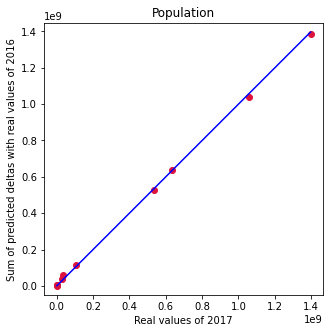

In [71]:
plt.figure(figsize=(5,5))
plt.scatter(p10["2017"], predicteddeltas2017pop + p10["2016"], c='crimson')

p1 = max(max(predicteddeltas2017pop + p10["2016"]), max(p10["2017"]))
p2 = min(min(predicteddeltas2017pop + p10["2016"]), min(p10["2017"]))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Real values of 2017')
plt.ylabel('Sum of predicted deltas with real values of 2016')
plt.title('Population')
plt.axis('equal')
plt.show()

In [72]:
# Fertility Rate Tests
ftest2017 = test_df(fertility_rate_df_last_6, idx)
ftest2017.rename(columns = { 0: 'D0', 1: 'D1', 2: 'D2'}, inplace = True)
predicteddeltas2017fr = pd.Series(best_model_fr.predict(ftest2017).reshape(1,10).tolist()[0], index = f10.index)
fresults = pd.concat([predicteddeltas2017fr, predicteddeltas2017fr + f10["2016"], f10["2017"]], axis = 1)
fresults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with real values of 2016", "2017": "Real values of 2017"}, inplace = True)
fresults = fresults.join(population_wb[["Country Name"]], how='inner')
fresults = fresults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with real values of 2016', 'Real values of 2017']]
fresults = fresults.set_index("Country Name")
fresults

,Predicted Deltas,Sum of predicted deltas with real values of 2016,Real values of 2017
Country Name,,,
Angola,-0.016391,5.669609,5.600000
China,-0.020925,1.654075,1.683000
Fiji,-0.019958,2.777042,2.788000
Croatia,-0.024315,1.405685,1.420000
IDA blend,-0.032732,4.200518,4.175809
IDA only,-0.032663,3.992640,3.968618
Latin America & Caribbean,0.000382,2.065797,2.046015
Morocco,-0.052771,2.436229,2.451000
Panama,-0.064126,2.449874,2.487000


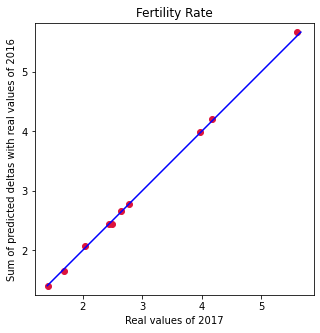

In [73]:
plt.figure(figsize=(5,5))
plt.scatter(f10["2017"], predicteddeltas2017fr + f10["2016"], c='crimson')

p1 = max(max(predicteddeltas2017fr + f10["2016"]), max(f10["2017"]))
p2 = min(min(predicteddeltas2017fr + f10["2016"]), min(f10["2017"]))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Real values of 2017')
plt.ylabel('Sum of predicted deltas with real values of 2016')
plt.title('Fertility Rate')
plt.axis('equal')
plt.show()

In [77]:
# Life expectancy Tests
ltest2017 = test_df(life_expectancy_df_last_6, idx)
ltest2017.rename(columns = { 0: 'D0', 1: 'D1', 2: 'D2'}, inplace = True)
ltest2017 = scaler_le.transform(ltest2017)
predicteddeltas2017le = pd.Series(best_model_le.predict(ltest2017).reshape(1,10).tolist()[0], index = l10.index)
lresults = pd.concat([predicteddeltas2017le, predicteddeltas2017le + l10["2016"], l10["2017"]], axis = 1)
lresults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with real values of 2016", "2017": "Real values of 2017"}, inplace = True)
lresults = lresults.join(population_wb[["Country Name"]], how='inner')
lresults = lresults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with real values of 2016', 'Real values of 2017']]
lresults = lresults.set_index("Country Name")
lresults

,Predicted Deltas,Sum of predicted deltas with real values of 2016,Real values of 2017
Country Name,,,
Angola,0.197892,60.122892,60.379000
China,0.159366,76.369366,76.470000
Fiji,0.191130,67.366130,67.252000
Croatia,0.226094,78.248045,77.826829
IDA blend,0.146242,61.734208,61.889129
IDA only,-0.096838,64.520235,64.973896
Latin America & Caribbean,0.166467,75.288491,75.282087
Morocco,0.325966,76.299966,76.218000
Panama,0.283472,78.247472,78.149000


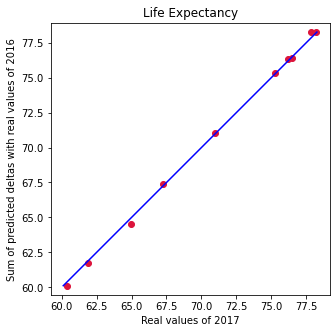

In [78]:
plt.figure(figsize=(5,5))
plt.scatter(l10["2017"], predicteddeltas2017le + l10["2016"], c='crimson')

p1 = max(max(predicteddeltas2017le + l10["2016"]), max(l10["2017"]))
p2 = min(min(predicteddeltas2017le + l10["2016"]), min(l10["2017"]))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Real values of 2017')
plt.ylabel('Sum of predicted deltas with real values of 2016')
plt.title('Life Expectancy')
plt.axis('equal')
plt.show()

## 2018

In [79]:
year2018column = pd.Series([2018 for i in range(10)], index=p10.index)

In [80]:
def test_2018_df(df, preds2017, idx):
    result = pd.DataFrame()
    d4 = df['2015'] - df['2014']
    d5 = df['2016'] - df['2015']
    result = pd.concat([d4, d5], axis = 1)
    result = result.iloc[idx]
    result = result.sort_index(ascending=True)
    result = result.join(preds2017[["Predicted Deltas"]])
    return result

In [81]:
# Population Tests
ptest2018 = test_2018_df(population_df_last_6, presults, idx)
predicteddeltas2018pop = pd.Series(best_model_pop.predict(ptest2018).reshape(1,10).tolist()[0], index = p10.index)
presults = pd.concat([predicteddeltas2018pop, predicteddeltas2018pop + predicteddeltas2017pop + p10["2016"], p10["2018"]], axis = 1)
presults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with predicted values of 2017", "2018": "Real values of 2018"}, inplace = True)
presults = presults.join(population_wb[["Country Name"]], how='inner')
presults = presults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with predicted values of 2017', 'Real values of 2018']]
presults = presults.set_index("Country Name")
presults

,Predicted Deltas,Sum of predicted deltas with predicted values of 2017,Real values of 2018
Country Name,,,
Angola,9.834042e+13,9.834045e+13,3.080979e+07
China,3.831954e+12,3.833342e+12,1.402760e+09
Fiji,7.663335e+12,7.663336e+12,8.834900e+05
Croatia,1.000850e+12,1.000855e+12,4.087843e+06
IDA blend,1.418783e+13,1.418836e+13,5.491278e+08
IDA only,1.094158e+13,1.094261e+13,1.084434e+09
Latin America & Caribbean,9.388526e+13,9.388590e+13,6.404838e+08
Morocco,3.690852e+14,3.690852e+14,3.602909e+07
Panama,1.477083e+13,1.477083e+13,4.176868e+06


In [82]:
# Fertility Rate Tests
ftest2018 = test_2018_df(fertility_rate_df_last_6, fresults, idx)
ftest2018.rename(columns = { 0: 'D0', 1: 'D1', "Predicted Deltas": "D2"}, inplace = True)
predicteddeltas2018fr = pd.Series(best_model_fr.predict(ftest2018).reshape(1,10).tolist()[0], index = f10.index)
fresults = pd.concat([predicteddeltas2018fr, predicteddeltas2018fr + predicteddeltas2017fr + f10["2016"], f10["2018"]], axis = 1)
fresults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with predicted values of 2017", "2018": "Real values of 2018"}, inplace = True)
fresults = fresults.join(population_wb[["Country Name"]], how='inner')
fresults = fresults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with predicted values of 2017', 'Real values of 2018']]
fresults = fresults.set_index("Country Name")
fresults

,Predicted Deltas,Sum of predicted deltas with predicted values of 2017,Real values of 2018
Country Name,,,
Angola,-0.038977,5.630632,5.519000
China,-0.009865,1.644211,1.690000
Fiji,-0.018904,2.758138,2.774000
Croatia,-0.017358,1.388327,1.470000
IDA blend,-0.045030,4.155488,4.133548
IDA only,-0.045030,3.947610,3.915852
Latin America & Caribbean,-0.014726,2.051071,2.027393
Morocco,-0.040473,2.395756,2.415000
Panama,-0.034456,2.415418,2.461000


In [83]:
# Life expectancy Tests
ltest2018 = test_2018_df(life_expectancy_df_last_6, lresults, idx)
ltest2018.rename(columns = { 0: 'D0', 1: 'D1', "Predicted Deltas": "D2"}, inplace = True)
predicteddeltas2018le = pd.Series(best_model_le.predict(ltest2018).reshape(1,10).tolist()[0], index = l10.index)
lresults = pd.concat([predicteddeltas2018le, predicteddeltas2018le + predicteddeltas2017le + l10["2016"], l10["2018"]], axis = 1)
lresults.rename(columns = {0: "Predicted Deltas", 1: "Sum of predicted deltas with predicted values of 2017", "2018": "Real values of 2018"}, inplace = True)
lresults = lresults.join(population_wb[["Country Name"]], how='inner')
lresults = lresults[['Country Name', 'Predicted Deltas', 'Sum of predicted deltas with predicted values of 2017', 'Real values of 2018']]
lresults = lresults.set_index("Country Name")
lresults

,Predicted Deltas,Sum of predicted deltas with predicted values of 2017,Real values of 2018
Country Name,,,
Angola,0.279738,60.402630,60.782000
China,0.244896,76.614262,76.704000
Fiji,0.165355,67.531485,67.341000
Croatia,0.250706,78.498751,78.070732
IDA blend,0.267383,62.001590,62.161867
IDA only,0.208246,64.728481,65.305310
Latin America & Caribbean,0.258284,75.546775,75.440849
Morocco,0.306270,76.606236,76.453000
Panama,0.281082,78.528554,78.329000
